In [2]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib.patches import Ellipse

from abc import ABC, abstractmethod

In [3]:
class Neuron:
    def __init__(self, mean, cov, coord):
        self.mean_ = mean
        self.cov_ = cov
        self.coord_ = coord

In [4]:
class Lattice(ABC):
    def __init__(self, size):
        self.size_ = size
        self.neurons_ = None
        self.neurons_nb_ = None

        self.generate()

    @abstractmethod
    def generate(self):
        pass


class RectangularLattice(Lattice):
    def generate(self):
        self.neurons_ = []
        self.neurons_nb_ = self.size_[0] * self.size_[1]

        for i in range(0, self.size_[0]):
            for j in range(0, self.size_[1]):
                self.neurons_.append(Neuron(None, None, np.array([i, j])))


In [253]:
class SOMM:
    def __init__(self, lattice: Lattice, learning_rate, random_state=None):
        self.learning_rate_ = learning_rate
        self.alpha_ = None
        self.lattice_ = lattice
        self.random_state = random_state

    def fit(self, X: np.ndarray, epochs):
        if self.random_state is not None:
            np.random.seed(self.random_state)

        neurons_nb = self.lattice_.neurons_nb_
        neurons = self.lattice_.neurons_


        for i in range(0, neurons_nb):
            neurons[i].mean_ = self.initialize_mean(X)
            neurons[i].cov_ = self.initialize_cov(X)
            print(neurons[i].cov_)

        for ep in range(epochs):
            self.alpha_ = np.sqrt(ep + 1) * self.learning_rate_
            print("Epoch:", ep)
            print("1/2*sigma^2:", self.alpha_)
            print("Weights, Covariance:")
            for neuron in self.lattice_.neurons_:
                print(neuron.mean_, end=' ')
                #print(neuron.cov_, end=' ')
            print()
            
            ### E-step ###
            bmus_idx = []
            for x in X:
                # Find best matching unit for x_n
                winner_idx = self.find_bmu(x)
                bmus_idx.append(winner_idx)
            #############

            # Update nodes
            ### M-step ###
            self.update_nodes(bmus_idx, X)

    def neighbourhood_func(self, r, s):
        # r - fixed neuron index
        # s - arbitrary neuron index

        numerator = np.exp(-self.alpha_ * self.distance(self.lattice_.neurons_[r].coord_, self.lattice_.neurons_[s].coord_))
        denominator = 0

        for neuron in self.lattice_.neurons_:
            denominator += np.exp(-self.alpha_ * self.distance(self.lattice_.neurons_[r].coord_, neuron.coord_))

        return numerator / denominator

    def find_bmu(self, x):
        # returns winner_idx
        min_d = np.inf
        winner_idx = None

        for i in range(self.lattice_.neurons_nb_):
            d = self.bmu_distance(x, i)
            if d < min_d:
                min_d = d
                winner_idx = i

        return winner_idx

    @staticmethod
    def distance(v1: np.ndarray, v2: np.ndarray):
        # Calculating euclidian distance
        return np.sqrt(np.sum((v1 - v2) ** 2))

    def bmu_distance(self, x, neuron_idx):
        distance = 0
        for i, neuron in enumerate(self.lattice_.neurons_):
            nb_val = self.neighbourhood_func(neuron_idx, i)

            distance += nb_val * ((np.log(np.linalg.det(neuron.cov_)) + (x - neuron.mean_).T @ np.linalg.inv(neuron.cov_) @ (x - neuron.mean_))/2 + np.log(nb_val))

        return distance

    def update_nodes(self, bmus_idx, X):
        # Updating all neuron based on batch mode

        for neuron_idx in range(self.lattice_.neurons_nb_):
            numerator_mean = 0
            numerator_cov = 0
            denominator = 0
            responsibilities = []

            for i, x in enumerate(X):
                responsibilities.append(self.neighbourhood_func(bmus_idx[i], neuron_idx))

                numerator_mean += responsibilities[i] * x
                denominator += responsibilities[i]

            self.lattice_.neurons_[neuron_idx].mean_ = numerator_mean / denominator

            for i, x in enumerate(X):
                numerator_cov += responsibilities[i] * np.outer((x - self.lattice_.neurons_[neuron_idx].mean_), 
                                                                (x - self.lattice_.neurons_[neuron_idx].mean_))

            self.lattice_.neurons_[neuron_idx].cov_ = (numerator_cov / denominator).reshape(X.shape[1], X.shape[1])
        
    def predict(self, X):
        probabilities = np.zeros((X.shape[0], self.lattice_.neurons_nb_))

        for i in range(X.shape[0]):
            # Find best matching unit for x_n
            winner_idx = self.find_bmu(X[i])
            for neuron_idx in range(self.lattice_.neurons_nb_):
                probabilities[i, neuron_idx] = self.neighbourhood_func(winner_idx, neuron_idx)
        
        return np.argmax(probabilities, axis=1)

            
    @staticmethod
    def initialize_mean(X):
        mean = np.zeros(X.shape[1])
        for i in range(0, X.shape[1]):
            mean[i] = np.random.uniform(np.min(X[:, i]), np.max(X[:, i]))

        return mean

    @staticmethod
    def initialize_cov(X):
        cov_matrix = np.zeros((X.shape[1], X.shape[1]))
        for i in range(0, X.shape[1]):
            cov_matrix[i, i] = np.random.uniform(0, (np.max(X[:, i]) - np.min(X[:, i]))/6)**2
            
        return cov_matrix

### Example 1

Text(0.5, 1.0, '1D Gaussian Mixture Dataset')

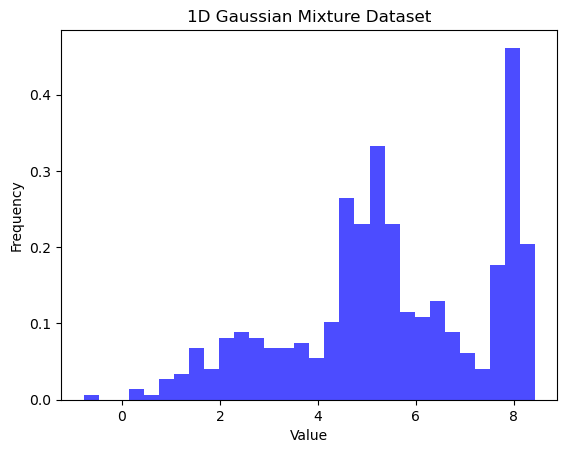

In [250]:
# Define the parameters for the Gaussian mixture
means = np.array([3, 5, 6, 8])
variances = np.array([1.2, 0.4, 0.9, 0.2])
n_samples = 120

# Generate data points from the Gaussian mixture
data = np.concatenate([np.random.normal(means[i], variances[i], n_samples) for i in range(len(means))])

# Visualize the generated data
hist_data, bin_edges, _ = plt.hist(data, bins=30, density=True, alpha=0.7, color='b')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('1D Gaussian Mixture Dataset')

In [251]:
data

array([ 2.03162175,  6.44618327,  2.2826125 ,  3.56694839,  4.31514734,
        1.54179744,  4.61082765,  2.85342025,  4.21501857,  1.90335702,
        1.76456375,  4.45175574,  3.60224676,  3.16661541,  3.76891334,
        3.6327992 ,  1.61476772,  0.34399982,  0.98189219,  0.8542869 ,
        0.33775807,  2.22308306,  2.36591482,  2.95294899,  3.25797114,
        2.53876944,  2.69531511,  3.08790249,  1.8033554 ,  2.14337245,
        3.04249962,  2.18646556,  2.31374273,  2.87296522,  4.60299761,
        3.38239835,  2.5948857 ,  2.29767807,  2.86209607,  5.69018135,
       -0.77689983,  3.64216307,  3.27898853,  4.04113434,  1.62214474,
        5.53721309,  4.20113131,  2.93830201,  3.19174524,  2.1404837 ,
        3.06062739,  2.8279951 ,  4.13229047,  3.42917307,  2.89986096,
        3.81336732,  3.66727245,  3.26726335,  1.16521742,  4.23505341,
        1.60048949,  1.78852602,  2.87367841,  3.61442659,  4.68927332,
        0.9747644 ,  4.76548079,  4.96375549,  2.44632608,  2.75

In [252]:
X = data.reshape(-1, 1)
X

array([[ 2.03162175],
       [ 6.44618327],
       [ 2.2826125 ],
       [ 3.56694839],
       [ 4.31514734],
       [ 1.54179744],
       [ 4.61082765],
       [ 2.85342025],
       [ 4.21501857],
       [ 1.90335702],
       [ 1.76456375],
       [ 4.45175574],
       [ 3.60224676],
       [ 3.16661541],
       [ 3.76891334],
       [ 3.6327992 ],
       [ 1.61476772],
       [ 0.34399982],
       [ 0.98189219],
       [ 0.8542869 ],
       [ 0.33775807],
       [ 2.22308306],
       [ 2.36591482],
       [ 2.95294899],
       [ 3.25797114],
       [ 2.53876944],
       [ 2.69531511],
       [ 3.08790249],
       [ 1.8033554 ],
       [ 2.14337245],
       [ 3.04249962],
       [ 2.18646556],
       [ 2.31374273],
       [ 2.87296522],
       [ 4.60299761],
       [ 3.38239835],
       [ 2.5948857 ],
       [ 2.29767807],
       [ 2.86209607],
       [ 5.69018135],
       [-0.77689983],
       [ 3.64216307],
       [ 3.27898853],
       [ 4.04113434],
       [ 1.62214474],
       [ 5

In [76]:
lattice = RectangularLattice((2, 2))
som = SOMM(lattice, 1.005, 42)

In [77]:
som.fit(X, 300)

[[1.]]
[[1.]]
[[1.]]
[[1.]]
Epoch: 0
1/2*sigma^2: 1.005
Weights, Covariance:
[5.42372638] [8.04472705] [8.118797] [7.45325135] 
Epoch: 1
1/2*sigma^2: 1.4212846301849604
Weights, Covariance:
[4.71520503] [5.49150116] [5.49150116] [6.65873185] 
Epoch: 2
1/2*sigma^2: 1.7407110616067214
Weights, Covariance:
[4.4099333] [5.50825082] [5.49044338] [6.95575361] 
Epoch: 3
1/2*sigma^2: 2.01
Weights, Covariance:
[4.21261699] [5.52958383] [5.4854502] [7.13486304] 
Epoch: 4
1/2*sigma^2: 2.2472483173872884
Weights, Covariance:
[3.95379417] [5.49304129] [5.49116061] [7.26512212] 
Epoch: 5
1/2*sigma^2: 2.4617371914970936
Weights, Covariance:
[3.59600776] [5.36336474] [5.53379911] [7.33420287] 
Epoch: 6
1/2*sigma^2: 2.6589800676199133
Weights, Covariance:
[3.27208047] [5.24381446] [5.59455327] [7.37612487] 
Epoch: 7
1/2*sigma^2: 2.842569260369921
Weights, Covariance:
[3.10566827] [5.19628835] [5.62499295] [7.42369351] 
Epoch: 8
1/2*sigma^2: 3.0149999999999997
Weights, Covariance:
[3.02313848] [5.179062

In [74]:
for neuron in som.lattice_.neurons_:
    print(neuron.mean_, neuron.cov_)

[2.67759043] [[0.93230934]]
[5.02282218] [[0.13518886]]
[6.42491946] [[0.24005549]]
[8.01214101] [[0.03934375]]


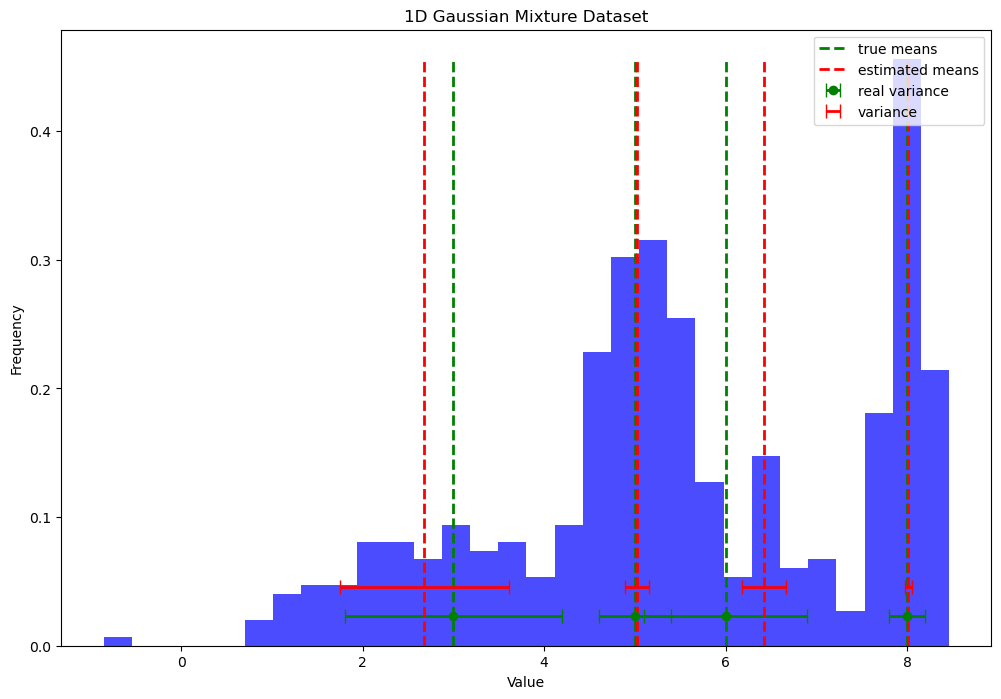

In [75]:
fig, ax = plt.subplots(figsize=(12, 8))

# Visualize the generated data
ax.hist(data, bins=30, density=True, alpha=0.7, color='b')
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title('1D Gaussian Mixture Dataset')

neuron_variances = np.array([neuron.cov_[0] for neuron in som.lattice_.neurons_]).flatten()
neuron_weights = np.array([neuron.mean_ for neuron in som.lattice_.neurons_]).flatten()

# Plot vertical lines for real means:
ax.vlines(x=means, color='g', linestyle='--', linewidth=2, label='true means', ymin=0, ymax=max(hist_data))
ax.errorbar(means, np.full(len(means), max(hist_data) * 0.05), xerr=variances, fmt='go', elinewidth=2, capsize=5, label='real variance')

# Plot vertical lines for neuron weights
ax.vlines(x=neuron_weights, color='r', linestyle='--', linewidth=2, label='estimated means', ymin=0, ymax=max(hist_data))
ax.errorbar(x=neuron_weights, y=np.full(len(neuron_weights), max(hist_data) * 0.1), xerr=neuron_variances, color='r', fmt='none', elinewidth=2, capsize=5, label='variance')


ax.legend(loc='upper right');

### Example 2

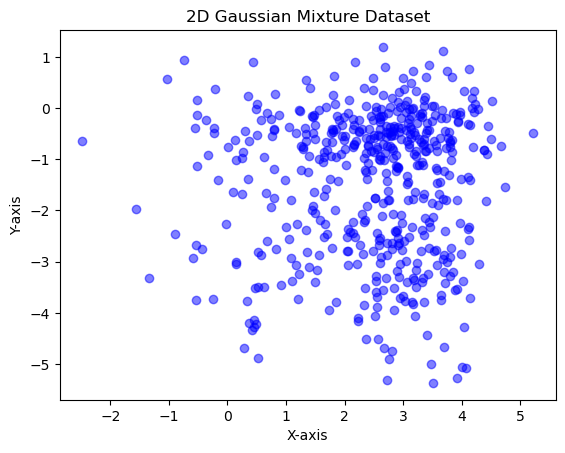

In [78]:
# Define the parameters for the 2D Gaussian mixture
means = np.array([[1, -3], [1, -0.5], [3, -3], [3, -0.5]])
covariances = np.array([[[1, 0], 
                         [0, 0.8]],

                        [[1, 0], 
                         [0, 0.3]],

                        [[0.5, 0], 
                         [0, 0.8]],

                        [[0.5, 0], 
                         [0, 0.3]]])

n_samples = [60, 90, 140, 210]

# Generate data points from the 2D Gaussian mixture
data = np.concatenate([np.random.multivariate_normal(mean, cov, n) for mean, cov, n in zip(means, covariances, n_samples)])
np.random.shuffle(data)

# Visualize the generated data
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, color='b')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('2D Gaussian Mixture Dataset')

plt.show()

In [39]:
data

array([[ 2.72379205e+00, -9.22519238e-01],
       [ 3.03496724e+00,  2.91542841e-01],
       [ 2.84063684e+00,  1.99756063e-01],
       [ 1.67102810e+00, -1.51671422e+00],
       [ 2.61624499e+00, -2.79965567e+00],
       [ 2.96412465e+00, -7.15440472e-01],
       [ 1.61365158e-01,  3.43646403e-01],
       [ 4.30371690e+00,  2.57653304e-02],
       [ 2.55006969e+00, -3.94337666e+00],
       [ 1.85372572e+00, -1.07401821e+00],
       [ 2.91956023e+00, -4.90540288e-01],
       [ 1.30841567e+00,  6.51040220e-02],
       [ 3.34258885e+00,  4.94884635e-01],
       [ 1.77891361e+00, -1.11137432e+00],
       [ 3.04985827e+00,  1.58859044e-01],
       [ 2.04832843e+00,  2.45174509e-01],
       [ 4.09122554e-01, -4.03021041e+00],
       [ 2.42696953e+00, -6.01816429e-01],
       [-1.13430392e+00,  3.92630245e-01],
       [ 1.55248628e+00, -2.66872157e+00],
       [ 2.64841458e+00,  5.21462202e-01],
       [ 3.73645812e+00, -2.41364394e+00],
       [ 2.96485747e+00, -1.23804843e+00],
       [ 3.

In [40]:
lattice = RectangularLattice((2, 2))
som = SOMM(lattice, 1.005)

In [41]:
som.fit(data, 200)

[[1. 0.]
 [0. 1.]]
[[1. 0.]
 [0. 1.]]
[[1. 0.]
 [0. 1.]]
[[1. 0.]
 [0. 1.]]
Epoch: 0
1/2*sigma^2: 1.005
Weights, Covariance:
[ 3.67838776 -3.6209912 ] [ 2.04122155 -4.15324009] [ 1.74067625 -0.93487693] [ 3.08369702 -0.69221616] 
Epoch: 1
1/2*sigma^2: 1.4212846301849604
Weights, Covariance:
[ 2.52053297 -2.00521222] [ 2.32460941 -1.98463902] [ 1.99484142 -1.15763492] [ 2.72525726 -1.05318175] 
Epoch: 2
1/2*sigma^2: 1.7407110616067214
Weights, Covariance:
[ 2.65190179 -2.36788798] [ 2.11906137 -2.09404638] [ 1.80810839 -0.99279327] [ 2.81942341 -0.85160517] 
Epoch: 3
1/2*sigma^2: 2.01
Weights, Covariance:
[ 2.7031497  -2.59146548] [ 1.93961906 -2.13076008] [ 1.66705144 -0.9032369 ] [ 2.86115123 -0.73203971] 
Epoch: 4
1/2*sigma^2: 2.2472483173872884
Weights, Covariance:
[ 2.74965838 -2.71975719] [ 1.79805195 -2.20528087] [ 1.53145974 -0.83498557] [ 2.88427344 -0.66424798] 
Epoch: 5
1/2*sigma^2: 2.4617371914970936
Weights, Covariance:
[ 2.78952761 -2.80826368] [ 1.66240185 -2.28773064] [ 

In [42]:
for neuron in som.lattice_.neurons_:
    print(neuron.mean_)
    print(neuron.cov_)
    print()

[ 3.10782508 -3.15123089]
[[0.38232515 0.03929621]
 [0.03929621 0.54906423]]

[ 1.05893775 -2.82845058]
[[0.76649641 0.1800803 ]
 [0.1800803  0.52343284]]

[ 1.01818697 -0.35780907]
[[0.93570567 0.02259456]
 [0.02259456 0.30876477]]

[ 3.2074762  -0.50654471]
[[ 3.02788396e-01 -2.22180020e-04]
 [-2.22180020e-04  2.79270576e-01]]



In [43]:
neuron_variances = np.array([neuron.cov_ for neuron in som.lattice_.neurons_])
neuron_weights = np.array([neuron.mean_ for neuron in som.lattice_.neurons_])

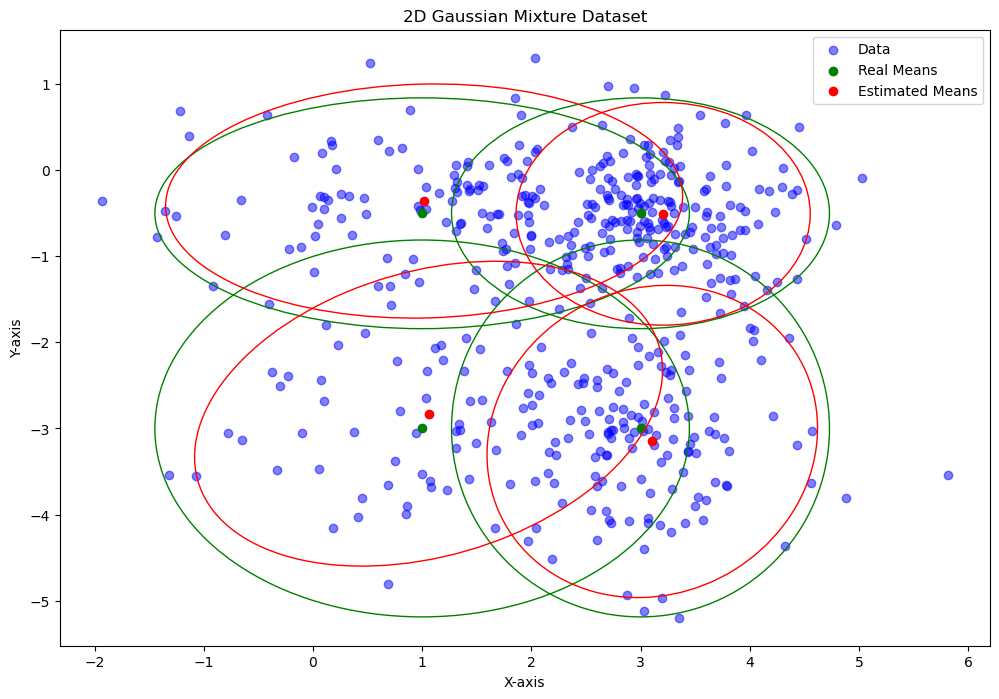

In [44]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(data[:, 0], data[:, 1], alpha=0.5, color='b', label='Data')

# Plot means as green points
ax.scatter(means[:, 0], means[:, 1], color='g', marker='o', label='Real Means')

# Plot true parameters
for mean, cov in zip(means, covariances):
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    width, height = 2 * np.sqrt(5.991 * eigenvalues)  # 95% confidence interval
    ell = Ellipse(xy=mean, width=width, height=height, angle=angle, color='g', fill=False)
    ax.add_patch(ell)

# Plot means as red points
ax.scatter(neuron_weights[:, 0], neuron_weights[:, 1], color='r', marker='o', label='Estimated Means')

# Plot neuron parameters
for mean, cov in zip(neuron_weights, neuron_variances):
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    width, height = 2 * np.sqrt(5.991 * eigenvalues)  # 95% confidence interval
    ell = Ellipse(xy=mean, width=width, height=height, angle=angle, color='r', fill=False)
    ax.add_patch(ell)

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('2D Gaussian Mixture Dataset')
ax.legend(loc='best');

### Example 3

In [151]:
def generate_mixture(means, variances, weights, n_samples):
    mixture_idx = np.random.choice(len(weights), size=n_samples, replace=True, p=weights)

    # y is the mixture sample
    data = np.concatenate([np.random.normal(means[i], variances[i]**0.5, size=1) for i in mixture_idx])
    return data, mixture_idx

def generate_independent_data(param1, param2):
    data1, labels1 = generate_mixture(param1[0], param1[1], param1[2], param1[3])
    data2, labels2 = generate_mixture(param2[0], param2[1], param2[2], param2[3])

    data = np.hstack((data1.reshape(-1, 1), data2.reshape(-1, 1)))
    labels = labels1 * len(np.unique(labels2)) + labels2

    return data, labels

In [152]:
n_samples = 700

# Define the parameters for the 2D Gaussian mixture
means1 = np.array([1, 5])
variances1 = np.array([1.2, 0.5])
weights1 = np.array([0.3, 0.7])
param1 = [means1, variances1, weights1, n_samples]

means2 = np.array([-8, -5])
variances2 = np.array([0.8, 0.6])
weights2 = np.array([0.4, 0.6])
param2 = [means2, variances2, weights2, n_samples]

In [153]:
data, labels = generate_independent_data(param1, param2)

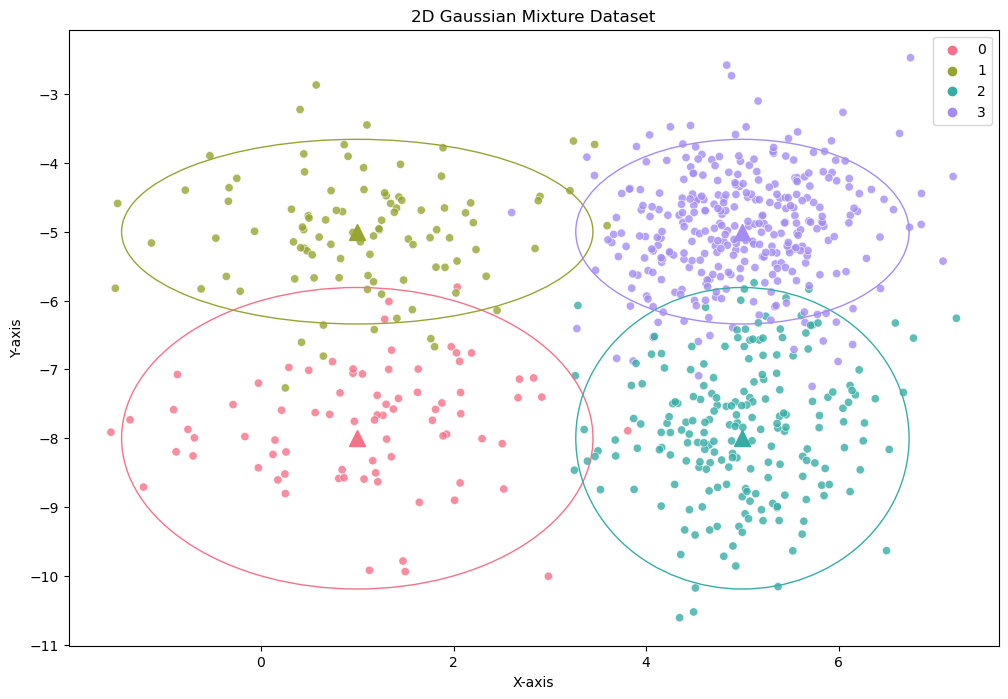

In [154]:
fig, ax = plt.subplots(figsize=(12, 8))

# Generate data points from the 2D Gaussian mixture

custom_palette = sns.color_palette("husl", len(np.unique(labels)))  # Use Seaborn's "husl" palette for n colors

# Visualize the generated data
sns.scatterplot(x=data[:, 0], y=data[:, 1], alpha=0.8, hue=labels, ax=ax, palette=custom_palette)

means = np.array([(x, y) for x in means1 for y in means2])
covariances = np.array([[[1, 0], [0, 0.8]], [[1, 0], [0, 0.3]], [[0.5, 0], [0, 0.8]], [[0.5, 0], [0, 0.3]]])

# Plot true parameters
for mean, cov, color in zip(means, covariances, custom_palette):
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    width, height = 2 * np.sqrt(5.991 * eigenvalues)  # 95% confidence interval
    ell = Ellipse(xy=mean, width=width, height=height, angle=angle, color=color, fill=False)
    ax.add_patch(ell)
    ax.plot(mean[0], mean[1], color=color, markersize=12, marker='^')


ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('2D Gaussian Mixture Dataset');

In [155]:
lattice = RectangularLattice((2, 2))
som = SOMM(lattice, 1.003, random_state=42)

In [156]:
som.fit(data, 100)

[[1.07117528 0.        ]
 [0.         0.81134522]]
[[0.0849976  0.        ]
 [0.         1.17390448]]
[[0.03012266 0.        ]
 [0.         1.31449189]]
[[0.26607653 0.        ]
 [0.         0.24856304]]
Epoch: 0
1/2*sigma^2: 1.003
Weights, Covariance:
[ 1.73004463 -2.87520766] [-0.18861719 -9.33757761] [ 3.71941702 -4.84828124] [ 5.75051938 -8.87940406] 
Epoch: 1
1/2*sigma^2: 1.4184562030602144
Weights, Covariance:
[ 3.97164139 -5.72342812] [ 3.15537189 -6.29812574] [ 4.33216366 -6.03011439] [ 4.34616888 -6.59504398] 
Epoch: 2
1/2*sigma^2: 1.7372469599915836
Weights, Covariance:
[ 4.1512652 -5.6107782] [ 2.40643244 -6.34720494] [ 4.66505167 -5.60991933] [ 4.40833847 -7.03864422] 
Epoch: 3
1/2*sigma^2: 2.006
Weights, Covariance:
[ 4.02894708 -5.63392919] [ 2.05420315 -6.37041351] [ 4.8134387  -5.41169834] [ 4.50605182 -7.23600778] 
Epoch: 4
1/2*sigma^2: 2.242776181432289
Weights, Covariance:
[ 3.95242875 -5.60922427] [ 1.82127763 -6.37875903] [ 4.88755374 -5.30233262] [ 4.57961576 -7.3

In [120]:
neuron_means = np.array([neuron.mean_ for neuron in som.lattice_.neurons_])
neuron_variances = np.array([neuron.cov_ for neuron in som.lattice_.neurons_])

In [121]:
neuron_means

array([[ 1.21848343, -4.91954631],
       [ 5.00311432, -4.92853222],
       [ 1.20296825, -8.17978284],
       [ 4.97496525, -7.86000893]])

In [122]:
means

array([[ 1, -8],
       [ 1, -5],
       [ 5, -8],
       [ 5, -5]])

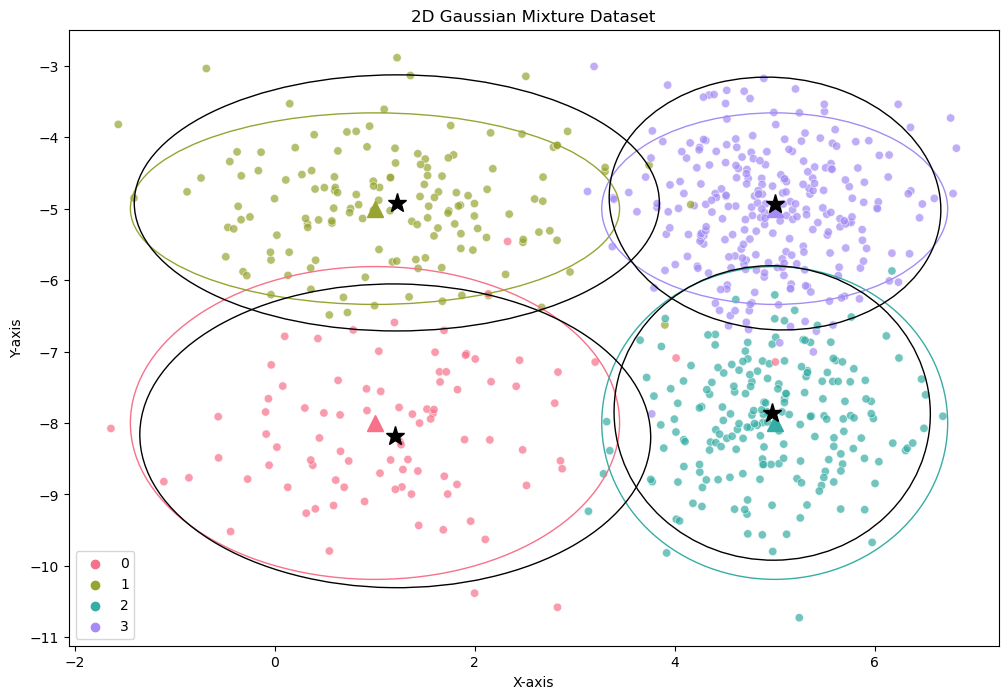

In [123]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.scatterplot(x=data[:, 0], y=data[:, 1], alpha=0.7, hue=labels, ax=ax, palette=custom_palette)


# Plot true parameters
for mean, cov, color in zip(means, covariances, custom_palette):
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    width, height = 2 * np.sqrt(5.991 * eigenvalues)  # 95% confidence interval
    ell = Ellipse(xy=mean, width=width, height=height, angle=angle, color=color, fill=False)
    ax.add_patch(ell)
    ax.plot(mean[0], mean[1], color=color, markersize=12, marker='^')


# Plot neuron parameters
for mean, cov in zip(neuron_means, neuron_variances):
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    width, height = 2 * np.sqrt(5.991 * eigenvalues)  # 95% confidence interval
    ell = Ellipse(xy=mean, width=width, height=height, angle=angle, color='black', fill=False)
    ax.add_patch(ell)
    ax.plot(mean[0], mean[1], color='black', markersize=14, marker='*')

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('2D Gaussian Mixture Dataset')
ax.legend(loc='best');

### Example 4

In [357]:
def covariance(prob_matrix):
    # TODO ??????
    x_vals = np.arange(prob_matrix.shape[1])
    y_vals = np.arange(prob_matrix.shape[0])

    mean_x = np.sum(prob_matrix * x_vals)
    mean_y = np.sum(prob_matrix * y_vals)
    var_x = np.sum(prob_matrix * (np.arange(prob_matrix.shape[1]) - mean_x) ** 2)
    var_y = np.sum(prob_matrix * (np.arange(prob_matrix.shape[0]) - mean_y) ** 2)


    # Calculate the covariance matrix
    cov_matrix = np.zeros((2, 2))
    for i in range(prob_matrix.shape[0]):
        for j in range(prob_matrix.shape[1]):
            cov_matrix[0, 1] += (i - mean_x) * (j - mean_y) * prob_matrix[i, j]


    cov_matrix[1, 0] = cov_matrix[0, 1]

    cov_matrix[0, 0] = var_x
    cov_matrix[1, 1] = var_y

    return cov_matrix

In [358]:
def generate_dependent_mixture(means1, variances1, means2, variances2, probabilities_matrix, n_samples):
    probabilities = probabilities_matrix.flatten()
    sample_index = np.random.choice(a=probabilities.size, p=probabilities, size=n_samples)
    adjusted_index = np.unravel_index(sample_index, probabilities_matrix.shape)
    mixture_indexes = np.vstack(adjusted_index)
    
    labels = []
    data = []
    for label, idx in zip(sample_index, mixture_indexes.T):
        mix1_idx = idx[0]
        mix2_idx = idx[1]

        mix1_val = np.random.normal(means1[mix1_idx], variances1[mix1_idx]**0.5)
        mix2_val = np.random.normal(means2[mix2_idx], variances2[mix2_idx]**0.5)
        
        data.append([mix1_val, mix2_val])
        labels.append(label)

    return np.array(data), np.array(labels)

In [368]:
n_samples = 500

# Define the parameters for the 2D Gaussian mixture
means1 = np.array([2, 7])
variances1 = np.array([1, 0.5])

means2 = np.array([-5, -1.5])
variances2 = np.array([1.2, 0.7])

probabilities = np.array([[0.25, 0.15],
                          [0.2, 0.4]])

In [399]:
data, labels = generate_dependent_mixture(means1, variances1, means2, variances2, probabilities, n_samples)

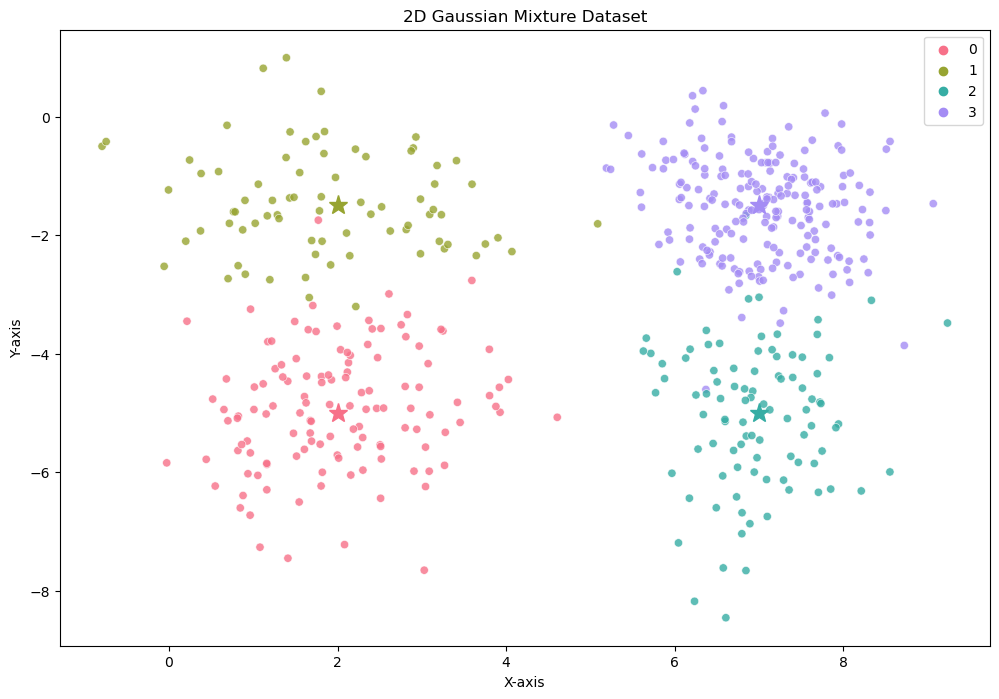

In [400]:
fig, ax = plt.subplots(figsize=(12, 8))

# Generate data points from the 2D Gaussian mixture

custom_palette = sns.color_palette("husl", len(np.unique(labels)))  # Use Seaborn's "husl" palette for n colors

# Visualize the generated data
sns.scatterplot(x=data[:, 0], y=data[:, 1], alpha=0.8, hue=labels, ax=ax, palette=custom_palette)

covariances = np.array([(x, y) for x in variances1 for y in variances2])
means = np.array([(x, y) for x in means1 for y in means2])
for mean, color in zip(means, custom_palette):
    ax.plot(mean[0], mean[1], color=color, markersize=14, marker='*')


ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('2D Gaussian Mixture Dataset');

In [392]:
lattice = RectangularLattice((2, 2))
som = SOMM(lattice, 1.002, random_state=42)

In [393]:
som.fit(data, 0)

[[0.19390801 0.        ]
 [0.         0.70645683]]
[[2.26891987 0.        ]
 [0.         0.00276998]]
[[0.22529734 0.        ]
 [0.         0.9109438 ]]
[[1.42746922e-05 0.00000000e+00]
 [0.00000000e+00 6.73719788e-01]]


In [394]:
neuron_means = np.array([neuron.mean_ for neuron in som.lattice_.neurons_])
neuron_variances = np.array([neuron.cov_ for neuron in som.lattice_.neurons_])

In [395]:
neuron_means

array([[ 0.75197534, -1.46375353],
       [-0.64864753,  0.22467556],
       [ 8.80712404, -7.15971627],
       [ 8.67944959, -0.39903657]])

In [396]:
means

array([[ 2. , -5. ],
       [ 2. , -1.5],
       [ 7. , -5. ],
       [ 7. , -1.5]])

In [ ]:
data

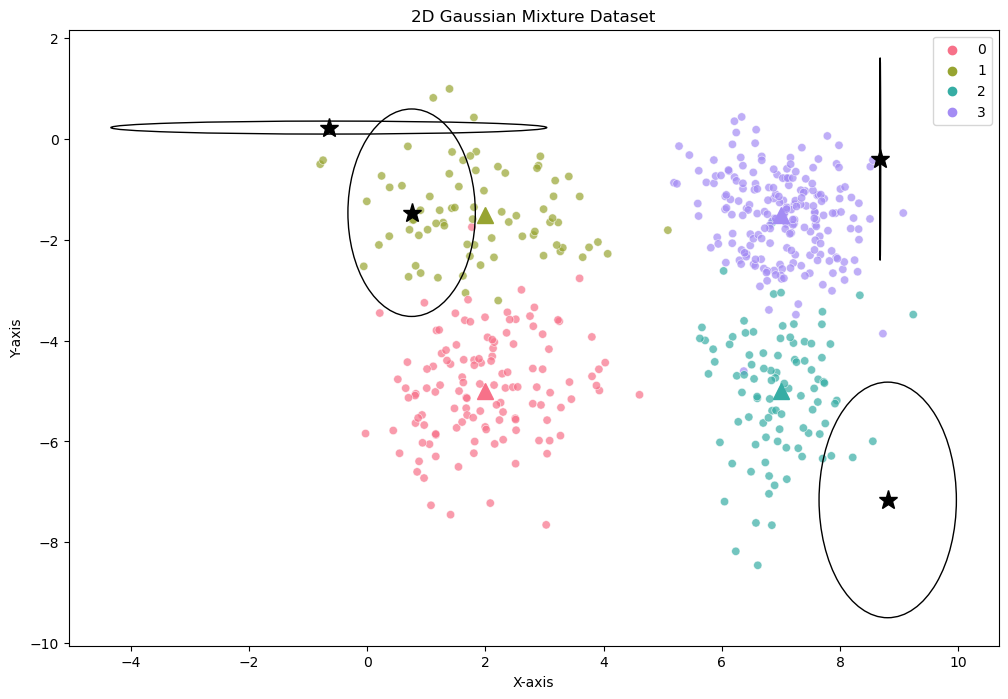

In [397]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.scatterplot(x=data[:, 0], y=data[:, 1], alpha=0.7, hue=labels, ax=ax, palette=custom_palette)


# Plot true parameters
for mean, color in zip(means, custom_palette):
    ax.plot(mean[0], mean[1], color=color, markersize=12, marker='^')


# Plot neuron parameters
for mean, cov in zip(neuron_means, neuron_variances):
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    width, height = 2 * np.sqrt(5.991 * eigenvalues)  # 95% confidence interval
    ell = Ellipse(xy=mean, width=width, height=height, angle=angle, color='black', fill=False)
    ax.add_patch(ell)
    ax.plot(mean[0], mean[1], color='black', markersize=14, marker='*')

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('2D Gaussian Mixture Dataset')
ax.legend(loc='best');

In [340]:
neuron_means

array([[ 3.97524521, -5.28014282],
       [ 3.9221174 , -2.54083996],
       [ 7.12559697, -4.68151585],
       [ 6.96029422, -2.17648197]])

In [341]:
res = som.predict(data)

In [343]:
res

array([0, 0, 0, 3, 3, 1, 1, 0, 3, 2, 0, 3, 3, 0, 3, 0, 0, 0, 0, 1, 3, 2,
       1, 1, 3, 2, 2, 3, 3, 2, 3, 2, 1, 0, 1, 3, 3, 1, 0, 2, 3, 3, 2, 3,
       1, 1, 3, 0, 3, 3, 3, 2, 2, 3, 2, 2, 3, 0, 0, 0, 2, 2, 0, 2, 2, 3,
       3, 3, 3, 3, 2, 3, 0, 0, 3, 0, 2, 1, 1, 0, 2, 3, 0, 3, 0, 1, 1, 1,
       0, 1, 2, 3, 3, 3, 2, 2, 2, 3, 2, 0, 3, 2, 1, 0, 1, 0, 3, 3, 3, 0,
       2, 3, 3, 2, 1, 3, 0, 3, 0, 3, 0, 0, 1, 3, 3, 3, 1, 3, 0, 2, 0, 3,
       0, 2, 0, 3, 3, 0, 3, 3, 0, 3, 2, 0, 3, 1, 1, 2, 1, 2, 0, 2, 3, 2,
       1, 1, 3, 1, 3, 1, 0, 2, 1, 0, 0, 1, 3, 2, 0, 0, 1, 0, 2, 0, 0, 1,
       2, 1, 3, 0, 2, 3, 3, 3, 3, 2, 1, 2, 0, 1, 1, 0, 3, 1, 2, 2, 1, 1,
       0, 2, 3, 3, 2, 1, 1, 1, 1, 3, 2, 0, 1, 1, 0, 1, 0, 0, 3, 0, 1, 2,
       2, 3, 2, 0, 2, 3, 2, 2, 2, 0, 3, 0, 2, 1, 3, 2, 1, 0, 3, 3, 0, 1,
       0, 2, 3, 0, 0, 2, 3, 3, 0, 1, 0, 3, 3, 0, 2, 3, 1, 2, 2, 3, 3, 0,
       3, 2, 3, 3, 2, 1, 3, 1, 3, 3, 1, 1, 1, 1, 3, 2, 1, 2, 3, 0, 3, 0,
       3, 3, 0, 3, 3, 3, 0, 3, 3, 0, 0, 3, 1, 0, 3,

In [398]:
np.savetxt("specific_data", data, delimiter=",")